In [1]:
from DataParser import get_df_list

# dfs containing only the signals captured when the machine is touching
df_list = get_df_list()

In [2]:
from Filter import filter_dataframes

filter_dataframes(df_list, win_size=20, alpha=8)


In [5]:
from Interpolate import cubic_interpolation_padded

interpolated = cubic_interpolation_padded(df_list, 0.003)
print(len(interpolated[0]))

702


In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from AE import AE


def get_auto():
    # Encoder
    encoder = tf.keras.Sequential([
        layers.Input(shape=(702, 2)),
        layers.Conv1D(filters=32, kernel_size=32, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=2),

        layers.Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=2),

        layers.Conv1D(filters=128, kernel_size=8, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=2),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='linear'),
    ])

    # Decoder
    decoder = tf.keras.Sequential([
        layers.Input(shape=(16,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(87 * 128, activation='relu'),
        layers.Reshape((87, 128)),

        layers.UpSampling1D(2),  # 320
        layers.Conv1DTranspose(filters=128, kernel_size=8, activation='relu', padding='same'),

        layers.UpSampling1D(2),  # 640
        layers.Conv1DTranspose(filters=64, kernel_size=16, activation='relu', padding='same'),
        layers.ZeroPadding1D(padding=(0, 3)),  # Pad to reach 1286 from 1280

        layers.UpSampling1D(2),  # 1280
        layers.Conv1DTranspose(filters=32, kernel_size=32, activation='relu', padding='same'),
        layers.Conv1DTranspose(filters=2, kernel_size=32, activation='linear', padding='same'),
    ])

    return encoder, decoder


# Create the autoencoder model
autoencoder = AE(*get_auto())
autoencoder.compile(optimizer='adam', loss='mse')

# Display model summary
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 702, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 351, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 351, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 175, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 175, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 87, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       712,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 815,952 (3.11 MB)

 Trainable params: 815,952 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 11136)          │       367,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 87, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 174, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 174, 128)       │       131,200 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 348, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 348, 64)        │       131,136 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_1                │ (None, 351, 64)        │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 702, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 702, 32)        │        65,568 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 702, 2)         │         2,050 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 697,986 (2.66 MB)

 Trainable params: 697,986 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

(6559, 702, 2)


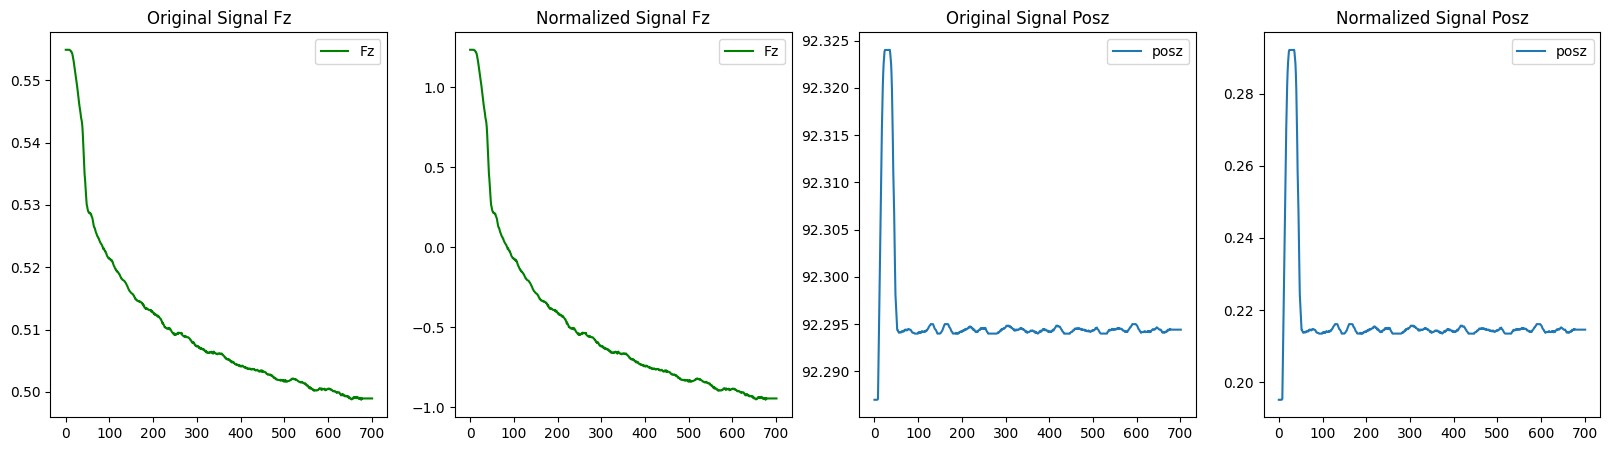

In [22]:
from sklearn.preprocessing import StandardScaler
from Scaler import preprocess_signals

scaler = StandardScaler()

# Standard scale the two features and stack into a np array
X_train, all_signals = preprocess_signals(interpolated, scaler)  

print(X_train.shape)
SIGNAL = 5

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Original Signal Fz")
plt.plot(all_signals[SIGNAL][:, 1], label='Fz', color="green")
plt.legend()

plt.subplot(1, 4, 2)
plt.title("Normalized Signal Fz")
plt.plot(X_train[SIGNAL][:, 1], label='Fz', color="green")
plt.legend()

plt.subplot(1, 4, 3)
plt.title("Original Signal Posz")
plt.plot(all_signals[SIGNAL][:, 0], label='posz')
plt.legend()

plt.subplot(1, 4, 4)
plt.title("Normalized Signal Posz")
plt.plot(X_train[SIGNAL][:, 0], label='posz')
plt.legend()

plt.show()

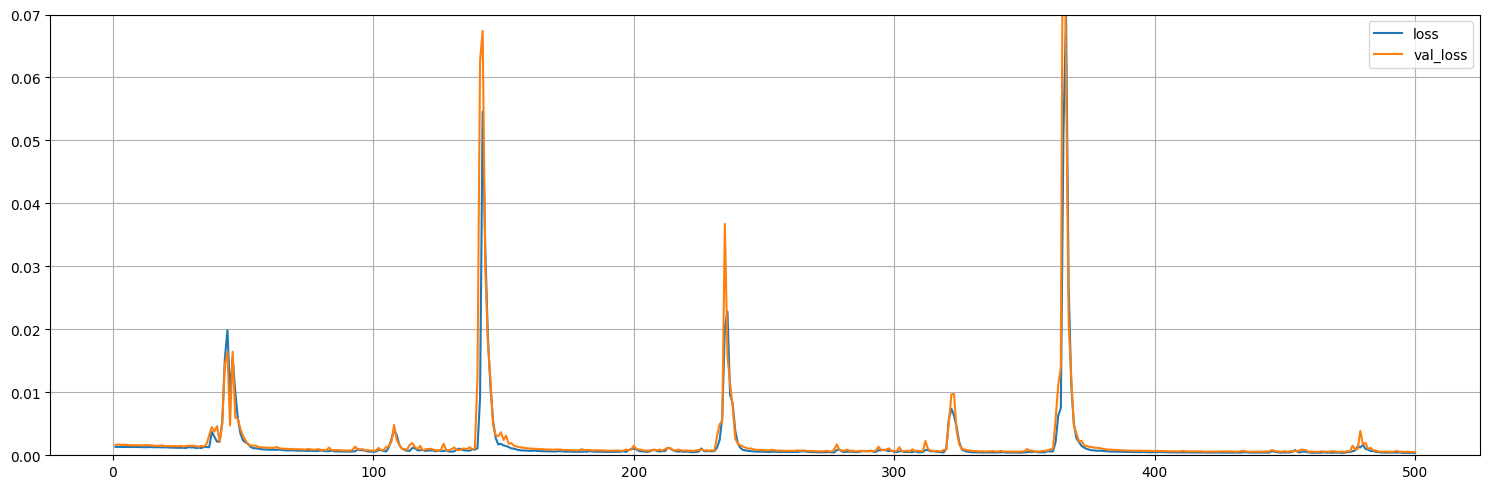

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 986ms/step - loss: 3.7922e-04 - val_loss: 5.2404e-04


In [10]:
%load_ext tensorboard
import tensorflow as tf
from plot_learning import PlotLearning

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

log_dir = "logs/"

early_stopping = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=False, monitor="val_loss",
                                                  mode="min")
checkpoint_callback = ModelCheckpoint(filepath='weights/normalized2bis.weights.h5', save_best_only=True,
                                      monitor="val_loss",
                                      mode='min', save_weights_only=True)
# Create TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the model with TensorBoard logging
autoencoder.fit(
    X_train, X_train,
    epochs=500,
    shuffle=True,

    batch_size=512,
    verbose=1,

    validation_split=0.2,
    callbacks=[tensorboard_callback, early_stopping, checkpoint_callback, PlotLearning(autoencoder)]
)

autoencoder.load_weights('weights/normalized2bis.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


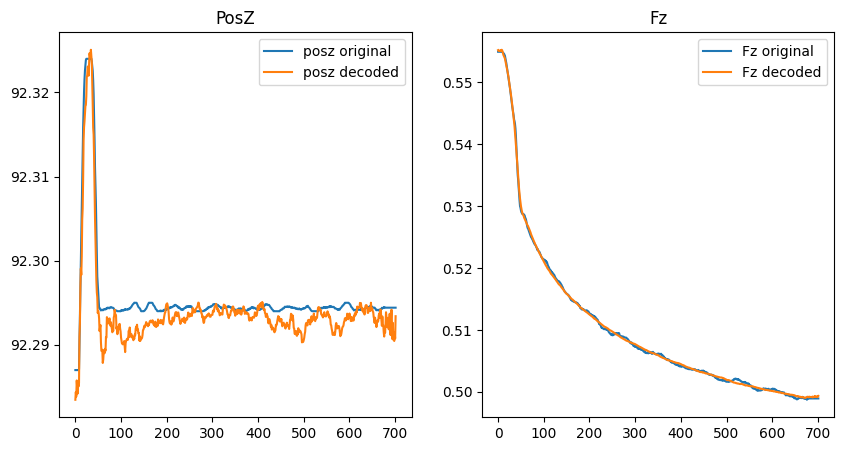

In [11]:
SIGNAL = 5

original = all_signals[SIGNAL]
sample_input = X_train[SIGNAL]
sample_input = sample_input.reshape(1, 702, 2)
reconstructed_scaled = autoencoder.predict(sample_input)
reconstructed = reconstructed_scaled.reshape(-1, 2)
original_scale = scaler.inverse_transform(reconstructed)
decoded = original_scale.reshape(sample_input.shape)
decoded = decoded.reshape(702, 2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot the original signal
plt.subplot(1, 2, 1)
plt.title("PosZ")
plt.plot(original[:, 0], label='posz original')
plt.plot(decoded[:, 0], label='posz decoded')
plt.legend()

# Plot the decoded signal
plt.subplot(1, 2, 2)
plt.title("Fz")
plt.plot(original[:, 1], label='Fz original')
plt.plot(decoded[:, 1], label='Fz decoded')
plt.legend()

plt.show()


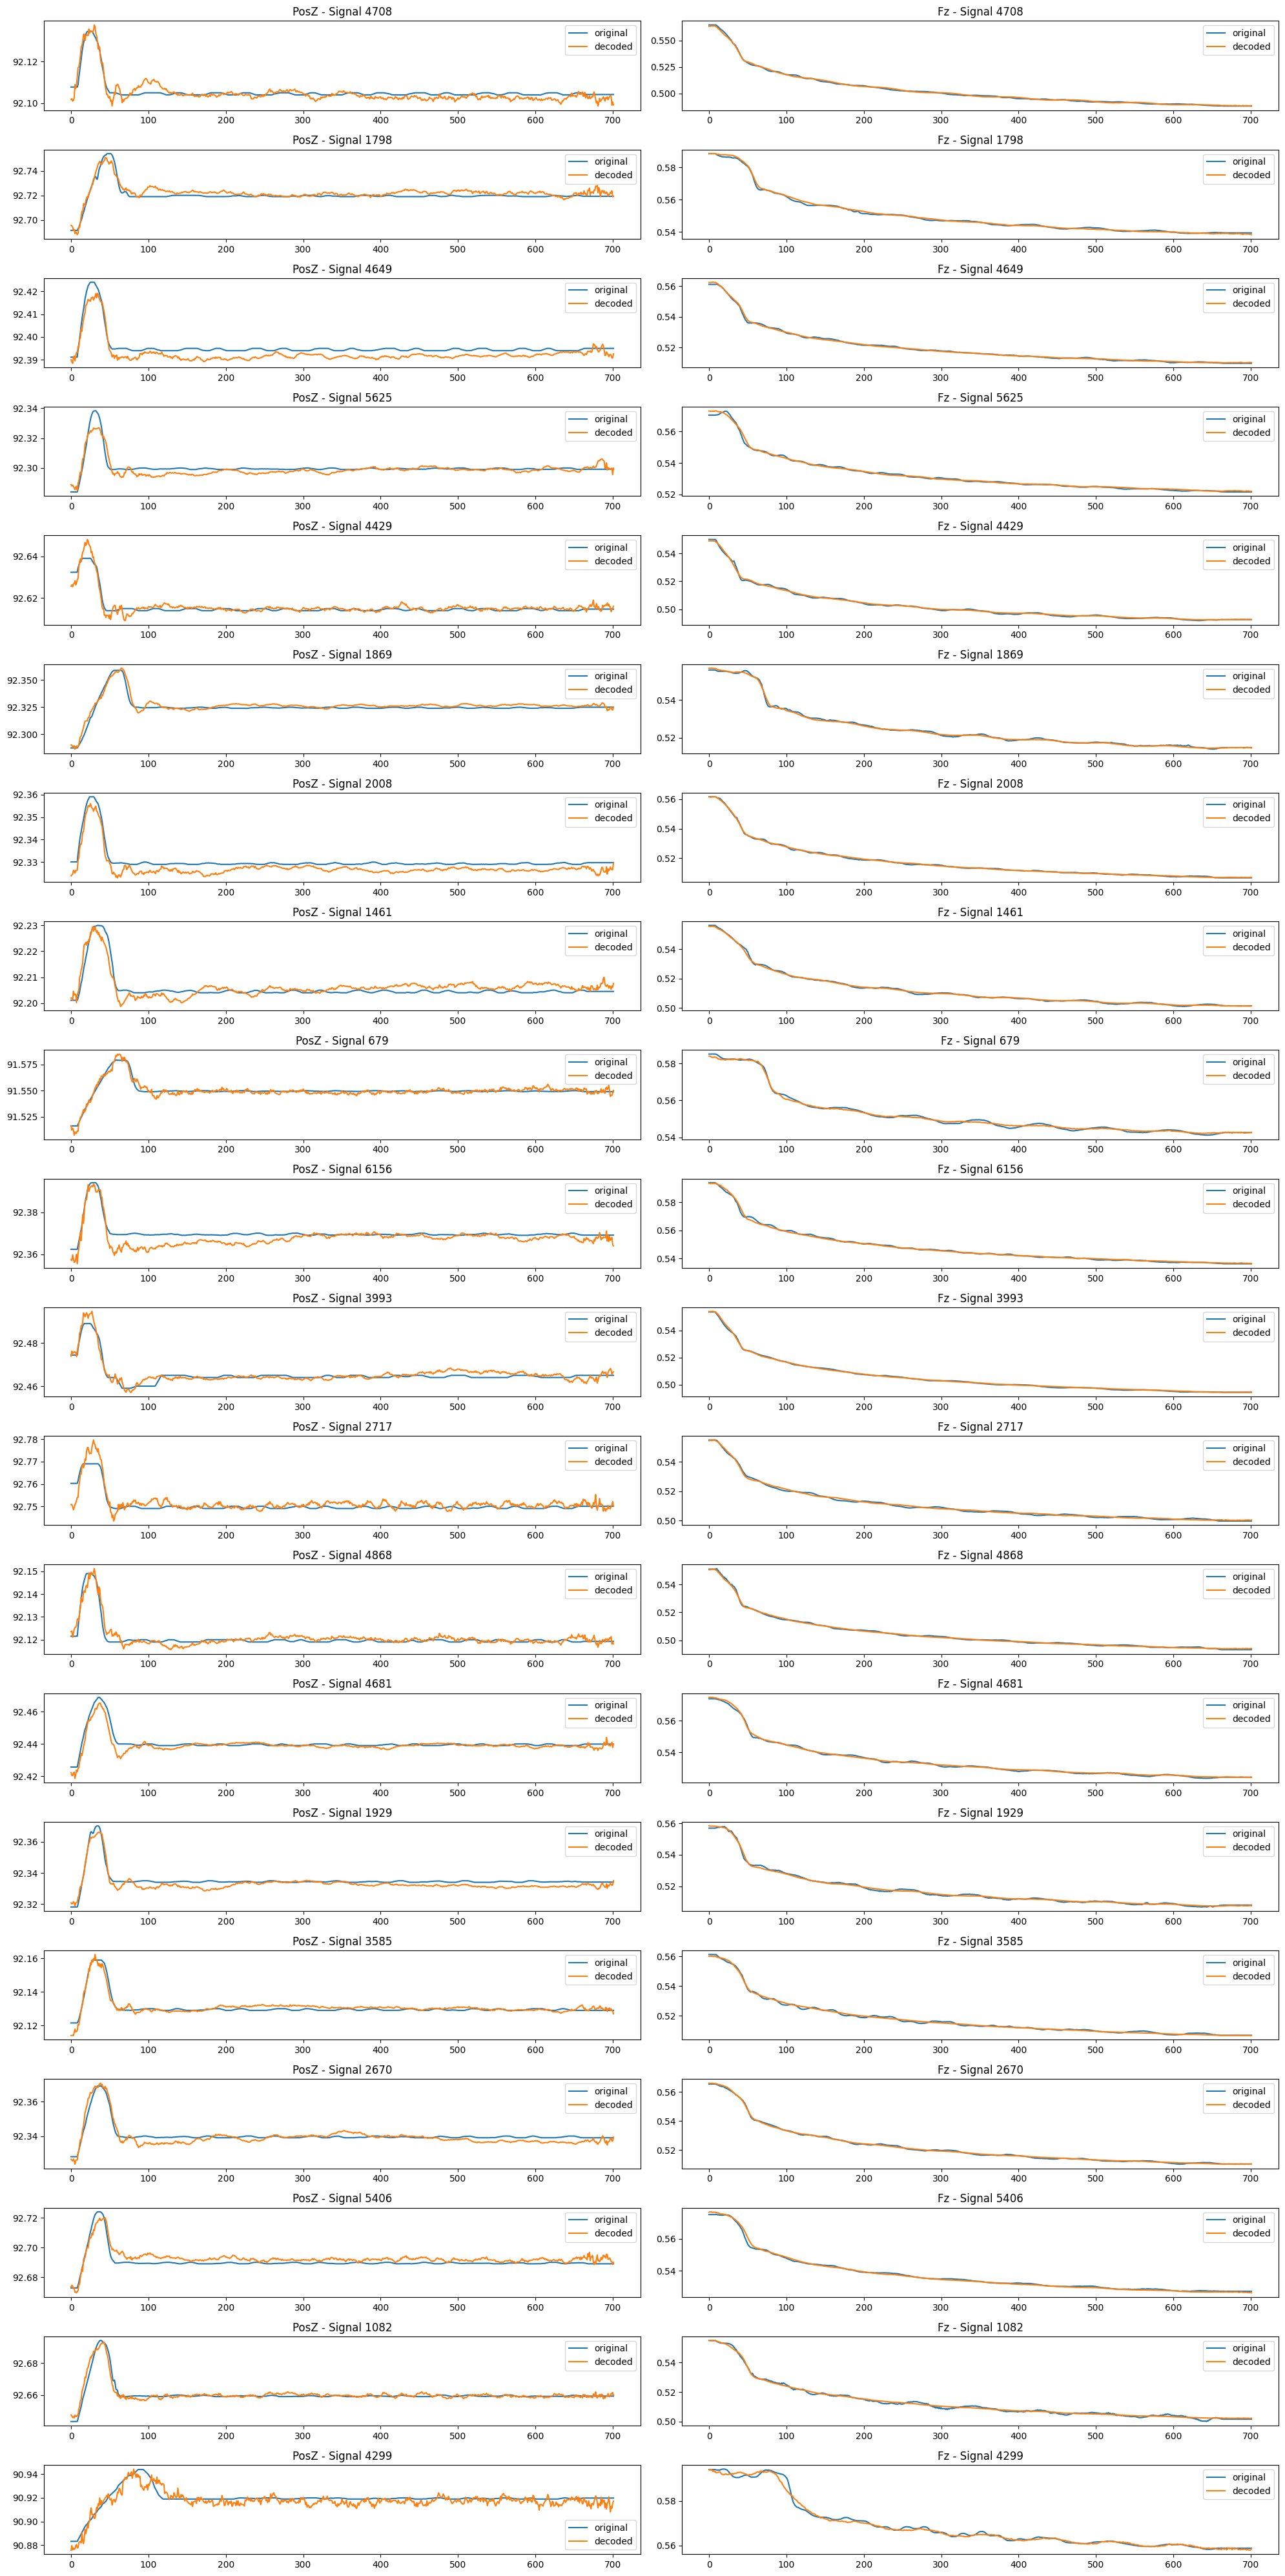

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Number of signals to display
NUM_SIGNALS = 20

# Get random indices
random_indices = random.sample(range(len(all_signals)), NUM_SIGNALS)

# Create a figure with appropriate size
plt.figure(figsize=(20, 40))

for i, idx in enumerate(random_indices):
    # Get original signal
    original = all_signals[idx]

    # Prepare input for autoencoder
    sample_input = X_train[idx]
    sample_input = sample_input.reshape(1, 702, 2)

    # Get reconstruction
    reconstructed_scaled = autoencoder.predict(sample_input, verbose=0)
    reconstructed = reconstructed_scaled.reshape(-1, 2)
    original_scale = scaler.inverse_transform(reconstructed)
    decoded = original_scale.reshape(702, 2)

    # Plot PosZ
    plt.subplot(NUM_SIGNALS, 2, 2 * i + 1)
    plt.title(f"PosZ - Signal {idx}")
    plt.plot(original[:, 0], label='original')
    plt.plot(decoded[:, 0], label='decoded')
    plt.legend()

    # Plot Fz
    plt.subplot(NUM_SIGNALS, 2, 2 * i + 2)
    plt.title(f"Fz - Signal {idx}")
    plt.plot(original[:, 1], label='original')
    plt.plot(decoded[:, 1], label='decoded')
    plt.legend()

plt.tight_layout()
plt.show()

  9/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

C:\Users\brill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Silhouette Score: 0.3205
Davies-Bouldin Index: 0.9830
Calinski-Harabasz Index: 4237.2864


C:\Users\brill\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


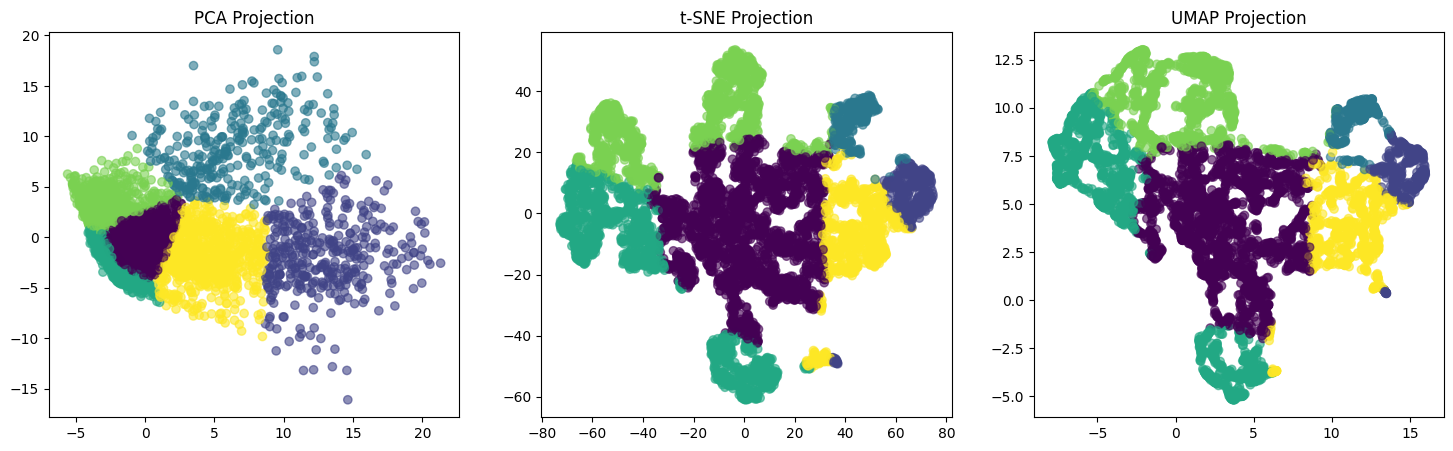

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

autoencoder.load_weights('weights/normalized2bis.weights.h5')

# Assume X_train is your 16D data from the autoencoder
X_train_encoded = autoencoder.encoder.predict(X_train)  # If using an autoencoder's latent space

# Clustering with KMeans (expected 6 clusters)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_train_encoded)

# Compute Clustering Metrics
silhouette_avg = silhouette_score(X_train_encoded, labels)
db_index = davies_bouldin_score(X_train_encoded, labels)
ch_index = calinski_harabasz_score(X_train_encoded, labels)

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

# Dimensionality Reduction
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_encoded)

# t-SNE
tsne = TSNE(n_components=2, perplexity=60, random_state=42)
X_tsne = tsne.fit_transform(X_train_encoded)

# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_train_encoded)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
axes[0].set_title("PCA Projection")

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
axes[1].set_title("t-SNE Projection")

axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', alpha=0.6)
axes[2].set_title("UMAP Projection")

plt.show()
